# Tentative inversion position et pression d'une chambre magmatique
- définition des modèles de déformation
- définition d'un cas d'étude 
- construction de données GNSS synthétiques
- inversion par metropolis


In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal, uniform
import emcee
import matplotlib.colors as colors
import matplotlib.cm as cmx

from utilities import *

plt.style.use("seaborn-v0_8-deep")

In [3]:
# Constantes du problème
G_hostrock = 2.1e9 # Host rock shear modulus (Pa)
nu_hostrock = 0.25 # Host rock Poisson ratio
mu_melt = 1. # Magma viscosity (Pa.s)

In [58]:
def sill_deform_pointsource(xg, yg, xs, ys, zs, Rs, p, G_hostrock = 2.1e9, nu_hostrock = 0.25):

    k = float((Rs**3)*(4/np.pi)*p*(1-nu_hostrock)/G_hostrock)
    R = np.sqrt((xs-xg)**2+(ys-yg)**2+zs**2)

    ux = k*(zs**2)/(R**5)*(xg-xs)
    uy = k*(zs**2)/(R**5)*(yg-ys)
    uz = k*(zs**2)/(R**5)*(zs*np.ones(xg.shape))
    
    return ux, uy, uz

def sill_deform_pointsource_k(xg, yg, xs, ys, zs, k, G_hostrock = 2.1e9, nu_hostrock = 0.25):

    R = np.sqrt((xs-xg)**2+(ys-yg)**2+zs**2)

    ux = k*(zs**2)/(R**5)*(xg-xs)
    uy = k*(zs**2)/(R**5)*(yg-ys)
    uz = k*(zs**2)/(R**5)*(zs*np.ones(xg.shape))
    
    return ux, uy, uz

def sill_deform_pointsource_mult_sills(x,y,sills_xyzR,sills_dp):
    
    n_sills = sills_xyzR.shape[0]
    ux,uy,uz = np.zeros((n_sills,*x.shape)),np.zeros((n_sills,*x.shape)),np.zeros((n_sills,*x.shape))
    
    for i in range(n_sills):
        xs,ys,zs,Rs = sills_xyzR[i,:]*1e3
        p = sills_dp[i]
        ux[i,:],uy[i,:],uz[i,:] = sill_deform_pointsource(x,y,xs,ys,zs,Rs,p)
        
    return ux.sum(axis=0),uy.sum(axis=0),uz.sum(axis=0)  

def sill_deform_pointsource_mult(x,y,sills_xyzR,p):
    
    n_time,n_sills = p.shape 
    ux,uy,uz = np.zeros((*p.shape,*x.shape)),np.zeros((*p.shape,*x.shape)),np.zeros((*p.shape,*x.shape))
    
    for i in range(n_sills):
        xs,ys,zs,Rs = sills_xyzR[i,:]*1e3
        for j in range(n_time):
            ux[j,i,:],uy[j,i,:],uz[j,i,:] = sill_deform_pointsource(x,y,xs,ys,zs,Rs,p[j,i])
        
    return ux.sum(axis=1),uy.sum(axis=1),uz.sum(axis=1)  

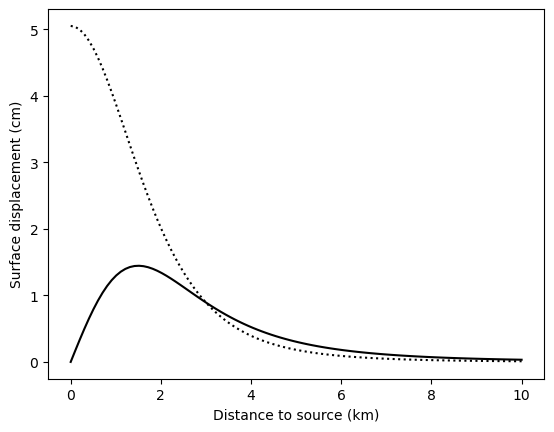

In [4]:
# Comparaison Mogi vs McTigue
x = np.linspace(0., 10e3, 100)
y = np.zeros(100)

ux,uy,uz = sill_deform_pointsource(x,y,0.,0.,3e3,1e3,1e6)

plt.plot(x*1e-3, uz*100, ":",c="k")
plt.plot(x*1e-3, ux*100,c="k")
plt.xlabel("Distance to source (km)")
plt.ylabel("Surface displacement (cm)")
plt.show()


In [5]:
# Random number generator
randomgen = np.random.default_rng(2000) # fixed seed, for reproductibility

In [6]:
# Définition de la source 
xs,ys,zs = 2e2,1e3,7e3
Rs = 1e3
dp = 1.5e6

ks = float((Rs**3)*(4/np.pi)*dp*(1-nu_hostrock)/G_hostrock)

In [7]:
# Tirage des stations GPS 
n_stations = 30

# Tirage en loi normale sur le rayon 
# r_stations_std = 3e3
# t_stations = randomgen.uniform(0., 2*np.pi, n_stations)
# r_stations = np.abs(randomgen.normal(0., r_stations_std, n_stations))
# x_stations = r_stations * np.cos(t_stations)
# y_stations = r_stations * np.sin(t_stations)

# Tirage homogène sur tout une surface
x_min,x_max = -5e3, 5e3
x_stations = randomgen.uniform(x_min,x_max, n_stations)
y_stations = randomgen.uniform(x_min,x_max, n_stations)

# Calcul des déplacements au niveau des stations
ux,uy,uz = sill_deform_pointsource_k(x_stations,y_stations,xs,ys,zs,ks)

# Ajout d'un bruit normal
sigma_noise = 1e-6
ux_obs = ux + randomgen.normal(0., sigma_noise, n_stations)
uy_obs = uy + randomgen.normal(0., sigma_noise, n_stations)
uz_obs = uz + randomgen.normal(0., sigma_noise, n_stations)

[]

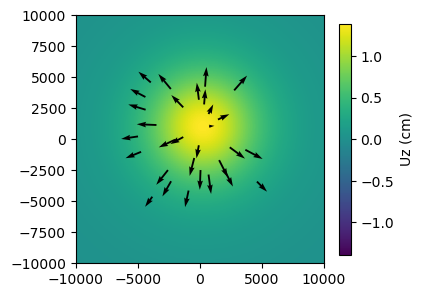

In [13]:
# Calcul du champ de déformation sur une grille pour plot
x_min,x_max = -10e3,10e3
n_x = 100
x = np.linspace(x_min,x_max,n_x)
xg, yg = np.meshgrid(x, x)

ux,uy,uz = sill_deform_pointsource_k(xg,yg,xs,ys,zs,ks)

# Plot 
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(uz*100, vmin=-np.max(np.abs(uz*100)),vmax=np.max(np.abs(uz*100)),extent=(x_min,x_max,x_min,x_max),origin="lower")
plt.colorbar(im, shrink=0.75,label="Uz (cm)")
ax.quiver(x_stations,y_stations,ux_obs,uy_obs,scale=5e-2)

plt.savefig("./figures_inversion/acquisition_setup.png",dpi=200)
plt.plot()

In [18]:
# Définition de la posterior à échantilloner

# Définition de la prior : uniform sur des plages de valeurs des paramètres
# ordre paramètres : x,y,z,R,p
min_max_param = np.array(
    [[-2.5e3,2.5e3],
     [-2.5e3,2.5e3],
     [3e3, 30e3],
     [5e2,3e3],
     [5e5, 2e6]]
)
loc = min_max_param[:,0]
scale = min_max_param[:,1] - min_max_param[:,0]
log_prior = lambda m : np.sum(uniform(loc,scale).logpdf(m))

# Définition de la lilelihood 
def prediction_sillpoint(m):
    ux,uy,uz = sill_deform_pointsource(x_stations,y_stations,*m)
    return np.hstack([ux,uy,uz])

d_obs = np.hstack([ux_obs,uy_obs,uz_obs])
cov_obs = np.ones(n_stations*3)*sigma_noise

log_likelihood = lambda m : multivariate_normal(mean=d_obs,cov=cov_obs).logpdf(prediction_sillpoint(m))

# Définition de la posterior
log_post = lambda m : log_prior(m) + log_likelihood(m)

n_samples = 2000 
n_dims = 5
n_walkers = 10
sampler = emcee.EnsembleSampler(n_walkers, n_dims, log_post)

# Définition des points de départs 
m0 = np.vstack([uniform(loc,scale).rvs() for _ in range(n_walkers)])
output = sampler.run_mcmc(m0, n_samples, progress=True)

  0%|          | 4/2000 [00:00<00:50, 39.55it/s]

100%|██████████| 2000/2000 [00:25<00:00, 79.51it/s]


[]

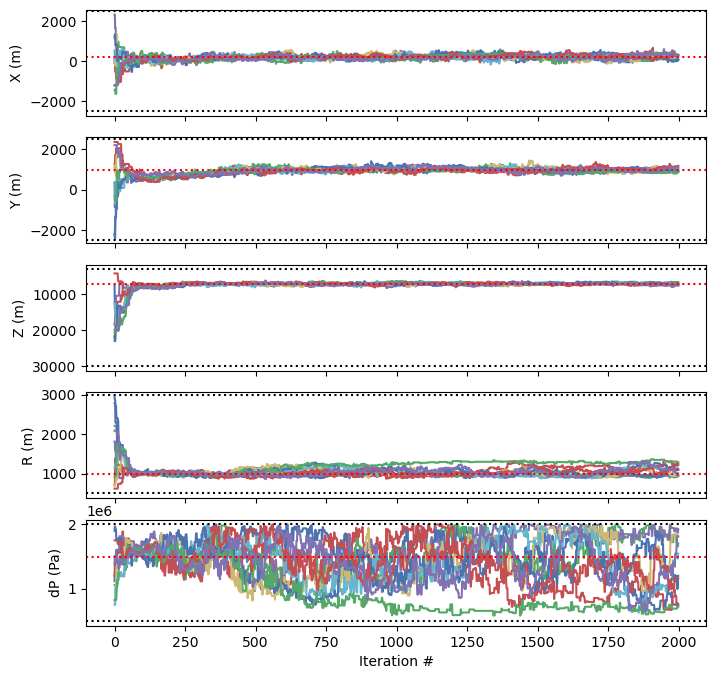

In [19]:
# Plot des chaînes de Markov
samples = sampler.get_chain()

param_labels = ["X (m)","Y (m)","Z (m)","R (m)", "dP (Pa)"]
param_true_values = [xs,ys,zs,Rs,dp]

fig,axs = plt.subplots(5,1,sharex=True,figsize=(8,8))

for i,(value,label) in enumerate(zip(param_true_values,param_labels)):
    for j in range(n_walkers):
        axs[i].plot(samples[:,j,i])
        
    min_p,max_p = min_max_param[i,:]
    axs[i].axhline(min_p,color="k",ls=":")
    axs[i].axhline(max_p,color="k",ls=":")
    axs[i].axhline(value,color="r",ls=":")
    axs[i].set_ylabel(label)
    
axs[2].invert_yaxis()
axs[-1].set_xlabel("Iteration #")
    
# plt.savefig("./figures_inversion/markov_chains_0.png",dpi=200.)
plt.plot()

### Inversion pour 2 chambres seulement

In [62]:
sills_xyzR = np.array([
    [1.1, -0.3, 5, 1.2],
    [-0.8, 1.1, 10, 1.9],
])
sills_dp = [0.6e6, 1.5e6]

# Tirage des stations 
n_stations = 30
x_min,x_max = -5e3, 5e3
x_stations = randomgen.uniform(x_min,x_max, n_stations)
y_stations = randomgen.uniform(x_min,x_max, n_stations)

# Calcul des déplacements au niveau des stations
ux,uy,uz = sill_deform_pointsource_mult_sills(x_stations,y_stations,sills_xyzR,sills_dp)

# Ajout d'un bruit normal
sigma_noise = 1e-6
ux_obs = ux + randomgen.normal(0., sigma_noise, n_stations)
uy_obs = uy + randomgen.normal(0., sigma_noise, n_stations)
uz_obs = uz + randomgen.normal(0., sigma_noise, n_stations)

[]

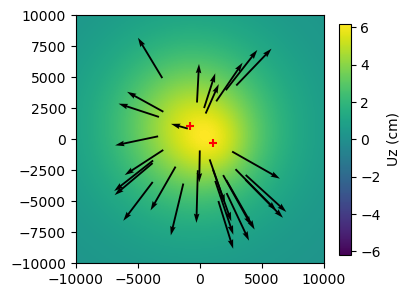

In [66]:
# Calcul du champ de déformation sur une grille pour plot
x_min,x_max = -10e3,10e3
n_x = 100
x = np.linspace(x_min,x_max,n_x)
xg, yg = np.meshgrid(x, x)

ux,uy,uz = sill_deform_pointsource_mult_sills(xg,yg,sills_xyzR,sills_dp)

# Plot 
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(uz*100, vmin=-np.max(np.abs(uz*100)),vmax=np.max(np.abs(uz*100)),extent=(x_min,x_max,x_min,x_max),origin="lower")
plt.colorbar(im, shrink=0.75,label="Uz (cm)")
xs,ys = sills_xyzR[:,0]*1e3,sills_xyzR[:,1]*1e3
ax.scatter(xs,ys,marker="+",color="r")
ax.quiver(x_stations,y_stations,ux_obs,uy_obs,scale=8e-2)

plt.savefig("./figures_inversion/acquisition_setup.png",dpi=200)
plt.plot()

In [67]:
# Définition de la posterior à échantilloner

# Définition de la prior : uniform sur des plages de valeurs des paramètres
# ordre paramètres : x,y,z,R,p
min_max_param = np.array(
    [[-2.5e3,2.5e3],
     [-2.5e3,2.5e3],
     [3e3, 30e3],
     [5e2,3e3],
     [5e5, 2e6]]
)
loc = min_max_param[:,0]
scale = min_max_param[:,1] - min_max_param[:,0]
log_prior = lambda m : np.sum(uniform(loc,scale).logpdf(m))

# Définition de la lilelihood 
def prediction_sillpoint(m):
    ux,uy,uz = sill_deform_pointsource(x_stations,y_stations,*m)
    return np.hstack([ux,uy,uz])

d_obs = np.hstack([ux_obs,uy_obs,uz_obs])
cov_obs = np.ones(n_stations*3)*sigma_noise

log_likelihood = lambda m : multivariate_normal(mean=d_obs,cov=cov_obs).logpdf(prediction_sillpoint(m))

# Définition de la posterior
log_post = lambda m : log_prior(m) + log_likelihood(m)

n_samples = 2000 
n_dims = 5
n_walkers = 10
sampler = emcee.EnsembleSampler(n_walkers, n_dims, log_post)

# Définition des points de départs 
m0 = np.vstack([uniform(loc,scale).rvs() for _ in range(n_walkers)])
output = sampler.run_mcmc(m0, n_samples, progress=True)

100%|██████████| 2000/2000 [00:28<00:00, 69.78it/s]


[]

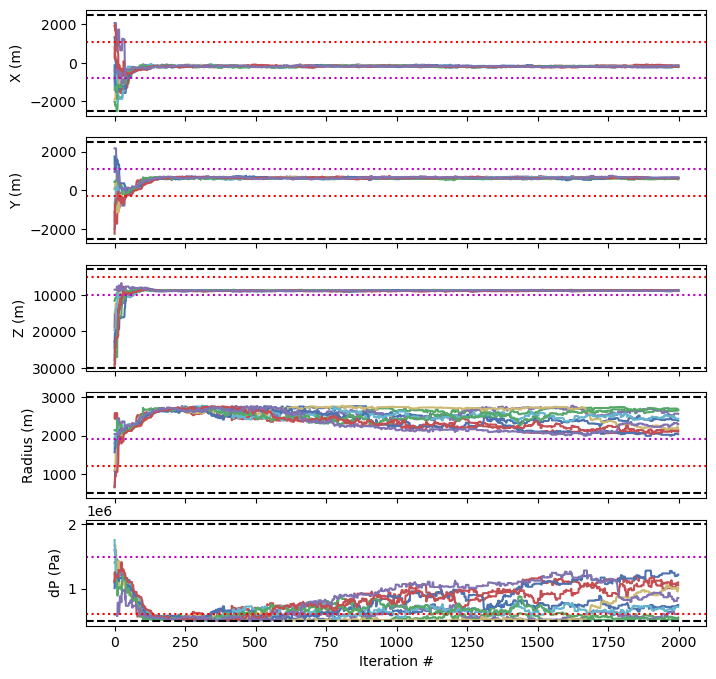

In [76]:
# Plot des chaînes de Markov
samples = sampler.get_chain()

param_labels = ["X (m)","Y (m)","Z (m)","Radius (m)", "dP (Pa)"]

fig,axs = plt.subplots(5,1,sharex=True,figsize=(8,8))

for i in range(5):
    for j in range(n_walkers):
        axs[i].plot(samples[:,j,i])
        
    min_p,max_p = min_max_param[i,:]
    axs[i].axhline(min_p,color="k",ls="--")
    axs[i].axhline(max_p,color="k",ls="--")
    
    if i < 4 :
        axs[i].axhline(sills_xyzR[0,i]*1e3,color="r",ls=":")
        axs[i].axhline(sills_xyzR[1,i]*1e3,color="m",ls=":")
    else : 
        axs[i].axhline(sills_dp[0],color="r",ls=":")
        axs[i].axhline(sills_dp[1],color="m",ls=":")
    
    axs[i].set_ylabel(param_labels[i])
    
axs[2].invert_yaxis()
axs[-1].set_xlabel("Iteration #")
    
plt.savefig("./figures_inversion/markov_chains_2_chambres.png",dpi=200.)
plt.plot()

## Inversion données avec réseau de chambres

In [6]:
# Tirage d'une géométrie
randomgen = np.random.default_rng(1232)

# Paramètres 
n_sills = 10 
volume_depth_top = 3. ; volume_depth_bottom = 30. 
volume_radius = 1. # pas utilisé directement, voir r_rnd_normal_std

r_rnd_normal_mean = 0. ; r_rnd_normal_std = 1.0
t_rnd_unif_min = 0.; t_rnd_unif_max = 2*np.pi
R_rnd_lognormal_mean = 0.; R_rnd_lognormal_std = 0.2
R_rnd_lognormal_scale = 1; # Radius of sills

r_rnd = np.abs(randomgen.normal(r_rnd_normal_mean, r_rnd_normal_std, n_sills))
t_rnd = randomgen.uniform(t_rnd_unif_min, t_rnd_unif_max, n_sills)
z_rnd = randomgen.uniform(volume_depth_top, volume_depth_bottom, n_sills)
R_rnd = R_rnd_lognormal_scale * randomgen.lognormal(R_rnd_lognormal_mean, R_rnd_lognormal_std, n_sills) 

x_rnd = r_rnd * np.cos(t_rnd)
y_rnd = r_rnd * np.sin(t_rnd)

sills_xyzR = np.vstack([x_rnd,y_rnd,z_rnd,R_rnd]).T

# Sort by decreasing depth
sills_xyzR = sills_xyzR[sills_xyzR[:,2].argsort()][::-1]

# Conduits
conduits_xyzz = make_sill_connections(sills_xyzR)

# graph associé
G = build_graph(sills_xyzR,conduits_xyzz)

# Résolution forçage
source = np.zeros(n_sills)
source[0] = 1
p_source = 1e6
p0 = np.zeros(n_sills)

t_stop = 3600*24*25
time = np.linspace(0.,t_stop,1000)
p = solve_analytically_forced(G, p0, source, p_source, time)

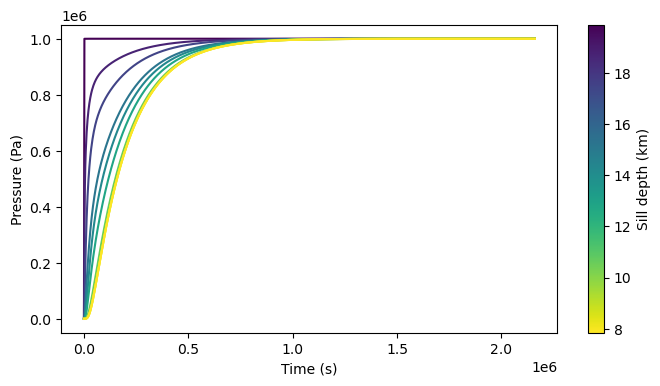

In [10]:
depths = sills_xyzR[:,2]
color_map = cmx.ScalarMappable(norm=colors.Normalize(vmin=depths[-1], vmax=depths[0]), cmap='viridis_r')

fig,ax = plt.subplots(1,1,figsize=(8,4))

for i in range(n_sills):
    ax.plot(time, p[:,i], color=color_map.to_rgba(depths[i]), label='%d' % i)
    
plt.colorbar(color_map,ax=ax, label="Sill depth (km)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Pa)")

plt.show()

In [36]:
# On tire nos stations
randomgen = np.random.default_rng(1231)

# Tirage des stations GPS 
n_stations = 30

# Tirage en loi normale sur le rayon 
# r_stations_std = 3e3
# t_stations = randomgen.uniform(0., 2*np.pi, n_stations)
# r_stations = np.abs(randomgen.normal(0., r_stations_std, n_stations))
# x_stations = r_stations * np.cos(t_stations)
# y_stations = r_stations * np.sin(t_stations)

# Tirage homogène sur tout une surface
x_min,x_max = -15e3, 15e3
x_stations = randomgen.uniform(x_min,x_max, n_stations)
y_stations = randomgen.uniform(x_min,x_max, n_stations)

# Calcul des déplacements au niveau des stations
ux,uy,uz = sill_deform_pointsource_mult(x_stations,y_stations,sills_xyzR,p[::100,:])

# Ajout d'un bruit normal
sigma_noise = 1e-3
ux_obs = ux + randomgen.normal(0., sigma_noise, (10,n_stations))
uy_obs = uy + randomgen.normal(0., sigma_noise, (10,n_stations))
uz_obs = uz + randomgen.normal(0., sigma_noise, (10,n_stations))

[]

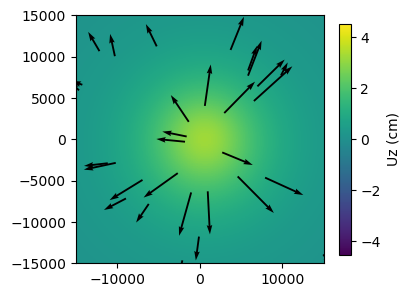

In [40]:
# Calcul du champ de déformation sur une grille pour plot
x_min,x_max = -15e3,15e3
n_x = 100
x = np.linspace(x_min,x_max,n_x)
xg, yg = np.meshgrid(x, x)

ux,uy,uz = sill_deform_pointsource_mult(xg,yg,sills_xyzR,p[::100,:])

# Plot 
it = 1
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(uz[it,:,:]*100, vmin=-np.max(np.abs(uz*100)),vmax=np.max(np.abs(uz*100)),extent=(x_min,x_max,x_min,x_max),origin="lower")
plt.colorbar(im, shrink=0.75,label="Uz (cm)")
ax.quiver(x_stations,y_stations,ux_obs[it,:],uy_obs[it,:],scale=5e-2)

plt.plot()

In [41]:
sills_xyzR

array([[-1.11122453, -0.37349759, 19.89368643,  0.94865465],
       [-0.10351606,  0.16622699, 18.73985799,  1.1642169 ],
       [ 0.86860891, -0.46294488, 17.47843352,  1.41101088],
       [ 0.074645  ,  0.07965243, 15.20492021,  0.94840609],
       [ 0.836699  , -0.3431818 , 14.25622255,  1.33354502],
       [ 0.37847467, -0.60496963, 12.78676672,  0.95807706],
       [ 0.72615458, -1.37541306, 10.5883279 ,  1.36297481],
       [ 0.07867717,  0.50256161,  8.71534327,  1.25896732],
       [ 0.79697989,  0.67277604,  7.86885122,  0.82534704],
       [ 1.05124406, -0.14470131,  7.83885266,  0.74139542]])

In [46]:
# Pour chaque temps, on performe une inversion

# Définition de la prior : uniform sur des plages de valeurs des paramètres
# ordre paramètres : x,y,z,R,p
min_max_param = np.array(
    [[-10e3,10e3],
     [-10e3,10e3],
     [3e3, 30e3],
     [5e2,1.5e3,],
     [0, 2e6]]
)
loc = min_max_param[:,0]
scale = min_max_param[:,1] - min_max_param[:,0]
log_prior = lambda m : np.sum(uniform(loc,scale).logpdf(m))

# Définition de la lilelihood 
def prediction_sillpoint(m):
    ux,uy,uz = sill_deform_pointsource(x_stations,y_stations,*m)
    return np.hstack([ux,uy,uz])

cov_obs = np.ones(n_stations*3)*sigma_noise

n_samples = 2000 
n_dims = 5
n_walkers = 10

m0 = np.vstack([uniform(loc,scale).rvs() for _ in range(n_walkers)])

samplers = []

for it in range(10):
    
    print("it = ",it)
    
    # On change seulement ce qui doit être changé
    d_obs = np.hstack([ux_obs[it,:],uy_obs[it,:],uz_obs[it,:]])
    log_likelihood = lambda m : multivariate_normal(mean=d_obs,cov=cov_obs).logpdf(prediction_sillpoint(m))
    log_post = lambda m : log_prior(m) + log_likelihood(m)
    
    sampler = emcee.EnsembleSampler(n_walkers, n_dims, log_post)
    output = sampler.run_mcmc(m0, n_samples, progress=True)

    samplers.append(sampler)

it =  9


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:25<00:00, 79.23it/s] 


it =  9


100%|██████████| 2000/2000 [00:22<00:00, 90.52it/s] 


it =  9


100%|██████████| 2000/2000 [00:21<00:00, 91.26it/s]


it =  9


100%|██████████| 2000/2000 [00:21<00:00, 91.35it/s]


it =  9


100%|██████████| 2000/2000 [00:21<00:00, 91.68it/s]


it =  9


100%|██████████| 2000/2000 [00:21<00:00, 92.41it/s]


it =  9


100%|██████████| 2000/2000 [00:23<00:00, 86.89it/s]


it =  9


100%|██████████| 2000/2000 [00:20<00:00, 96.42it/s] 


it =  9


100%|██████████| 2000/2000 [00:24<00:00, 81.84it/s]


it =  9


100%|██████████| 2000/2000 [00:25<00:00, 79.65it/s]


[]

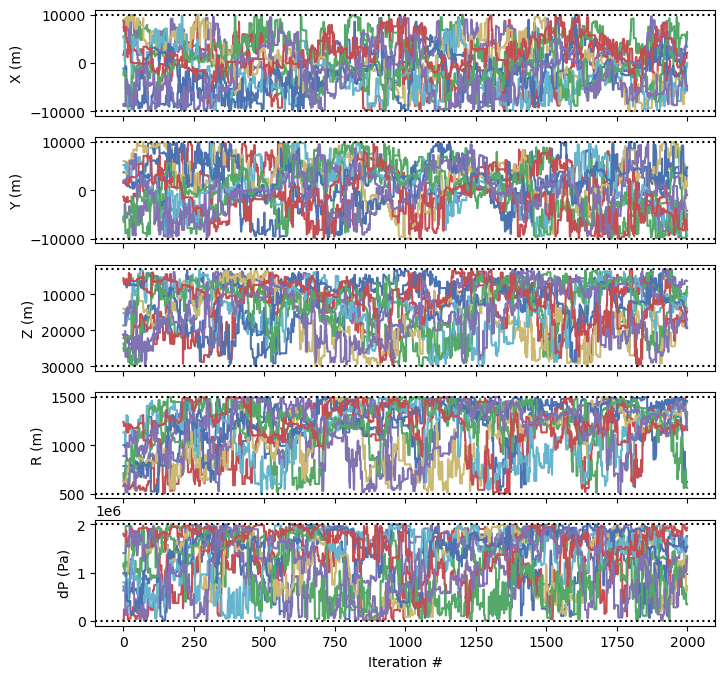

In [54]:
it = 8

# Plot des chaînes de Markov
samples = samplers[it].get_chain()

param_labels = ["X (m)","Y (m)","Z (m)","R (m)", "dP (Pa)"]

fig,axs = plt.subplots(5,1,sharex=True,figsize=(8,8))

for i,label in enumerate(param_labels):
    for j in range(n_walkers):
        axs[i].plot(samples[:,j,i])
        
    min_p,max_p = min_max_param[i,:]
    axs[i].axhline(min_p,color="k",ls=":")
    axs[i].axhline(max_p,color="k",ls=":")
    axs[i].set_ylabel(label)
    
axs[2].invert_yaxis()
axs[-1].set_xlabel("Iteration #")
    
# plt.savefig("./figures_inversion/markov_chains_not_converging.png",dpi=200.)
plt.plot()

In [ ]:
k_pR = lambda dp,Rs : float((Rs**3)*(4/np.pi)*dp*(1-nu_hostrock)/G_hostrock)
print(k_pR(0.5e6,1e3))
print(k_pR(3e6, 5e3))

In [ ]:
# Pour évaluation à 4 paramètres

# Définition de la posterior à échantilloner

# Définition de la prior : uniform sur des plages de valeurs des paramètres
min_max_param = np.array(
    [[-2.5e3,2.5e3],
     [-2.5e3,2.5e3],
     [3e3, 30e3],
     [1e5, 1e8]] # paramètre k : fonction de dp et de R
)
loc = min_max_param[:,0]
scale = min_max_param[:,1] - min_max_param[:,0]
log_prior = lambda m : np.sum(uniform(loc,scale).logpdf(m))

# Définition de la lilelihood 
def prediction_sillpoint(m):
    ux,uy,uz = sill_deform_pointsource_k(x_stations,y_stations,*m)
    return np.hstack([ux,uy,uz])

d_obs = np.hstack([ux_obs,uy_obs,uz_obs])
cov_obs = np.ones(n_stations*3)*sigma_noise

log_likelihood = lambda m : multivariate_normal(mean=d_obs,cov=cov_obs).logpdf(prediction_sillpoint(m))

# Définition de la posterior
log_post = lambda m : log_prior(m) + log_likelihood(m)

n_samples = 2000 
n_dims = 4
n_walkers = 10
sampler = emcee.EnsembleSampler(n_walkers, n_dims, log_post)

# Définition des points de départs 
m0 = np.vstack([uniform(loc,scale).rvs() for _ in range(n_walkers)])
output = sampler.run_mcmc(m0, n_samples, progress=True)

In [ ]:
# Plot des chaînes de Markov
samples = sampler.get_chain()

param_labels = ["X (m)","Y (m)","Z (m)","k"]
param_true_values = [xs,ys,zs,ks]

fig,axs = plt.subplots(4,1,sharex=True,figsize=(8,8))

for i,(value,label) in enumerate(zip(param_true_values,param_labels)):
    for j in range(n_walkers):
        axs[i].plot(samples[:,j,i])
    axs[i].axhline(value,color="k",ls=":")
    axs[i].set_ylabel(label)
    
plt.plot()